# Butyrate biosynthesis in the DeepDive

Using the updated shortbred files, let's look at this again.

1. What are the patterns in overall butyrate gene abundance?
2. Do we see shifts in the dominant butyrate synthesis pathway? Can this change with FMT and/or antibiotics?
3. Do we see engraftment of novel taxa and their corresponding butyrate pathways/genes?
4. What about the overall richness/diversity of butyrate pathways?

In [1]:
import pathlib, itertools
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [3]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metadata/metadata_stooldna_OC162018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})

md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [4]:
#read in sb results file
buty = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metagenomics/function/butyrate/sb_OC312018/all_sbresults_nz.txt.gz',
                     sep='\t', compression='gzip')

In [6]:
#read in data on the genes and pathways
gene_map = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metagenomics/function/butyrate/butyrate_genes_vital_2017_geneids.map',
                       sep='\t')
#parse vital labels
gene_map.loc[:, 'gene_label'] = gene_map['vital2017_faa_label'].str.split('%fig').str[0]
gene_map.loc[:, 'taxa'] = gene_map['vital2017_faa_label'].str.extract(r'(\[.*\])')[0]

#import pathway information
pathways = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metagenomics/function/butyrate/butyrate_genes_vital_2017_pathways.tsv',
                       sep='\t')

#read in clusters
gene_clusters = pd.read_csv('/Users/ndchu/Documents/MIT/uc_fmt/metagenomics/function/butyrate/sb_OC312018/clust.map',
                       sep='\t', header=None, names=['gene_cluster_rep', 'clustered_genes'])
#add gene information to clusters
gene_clusters = gene_clusters.merge(gene_map, left_on='clustered_genes', right_on='butyrate_gene_ids')

The gene clusters (as expected) largely cluster together genes from very similar organisms. In particular, it appears that the largest clusters are from genes pulled from many different clinical isolates, like Clostridium difficile.

In [7]:
#get only the markers with registered counts, which require hits for all markers
buty_f = buty.loc[buty['Count'] > 0]
#add gene information
buty_f = buty_f.merge(gene_map, left_on='Family', right_on='butyrate_gene_ids')

In [8]:
buty_f_md = buty_f.merge(md, left_on='sample', right_on='sample_id')

In [9]:
#get samples that have mgx sequencing
samples = md.loc[(md['reads_mgx'] > 0) & (md['patient'].notnull())]['sample_id'].unique()

## Cumulative abundance of butyrate synthesis genes

In [145]:
# get sum of butyrate gene hits
buty_sum = buty_f[['sample', 
                   'Count', 
                   'Hits']].groupby('sample').sum().reset_index()

#add any missing samples
sam_missing = [x for x in samples if x not in buty_sum['sample']]
missing_df = pd.DataFrame({'sample': sam_missing,
                           'Count': [0] * len(sam_missing), 
                           'Hits': [0] * len(sam_missing)})
buty_sum = buty_sum.append(missing_df)

#add metadata
buty_sum = buty_sum.merge(md, left_on='sample', right_on='sample_id')

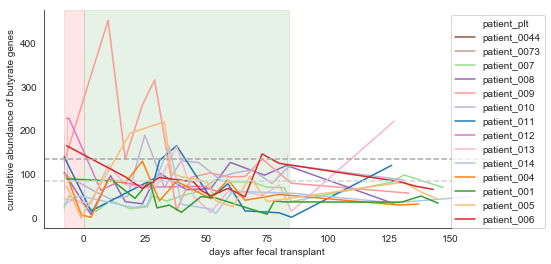

In [9]:
# for each patient, plot the total butyrate abundance over time

#get mean abundance for each donor
buty_mean_0044 = buty_sum.loc[buty_sum['patient'] == '0044']['Count'].mean()
buty_mean_0073 = buty_sum.loc[buty_sum['patient'] == '0073']['Count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='Count',
                  data=buty_sum,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('cumulative abundance of butyrate genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

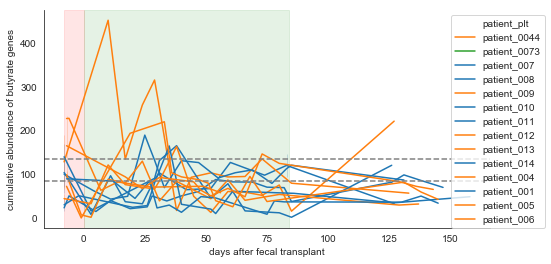

In [10]:
# for each patient, plot the total butyrate abundance over time

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='Count',
                  data=buty_sum,
                  hue='patient_plt', palette=dd_treat_col_name)

#label axes
ax.set_ylabel('cumulative abundance of butyrate genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='grey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='grey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

## Diversity of Butyrate genes (counts of shortbred clusters)

These will consider how many different shortbred clusters (which reflects both gene information and the species, although not comprehensivey, since some genes from multiple species are clustered together) combinations occur in each sample.

In [9]:
# get count of butyrate gene cluster hits
buty_ct = buty_f[['sample', 
                  'Count', 
                  'Hits']].groupby('sample').size().rename('sb_clust_count').reset_index()

#add any missing samples
sam_missing = [x for x in samples if x not in buty_ct['sample'].values]
missing_df = pd.DataFrame({'sample': sam_missing,
                           'Count': [0] * len(sam_missing), 
                           'Hits': [0] * len(sam_missing)})
buty_ct = buty_ct.append(missing_df)

#add metadata
buty_ct = buty_ct.merge(md, left_on='sample', right_on='sample_id')

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


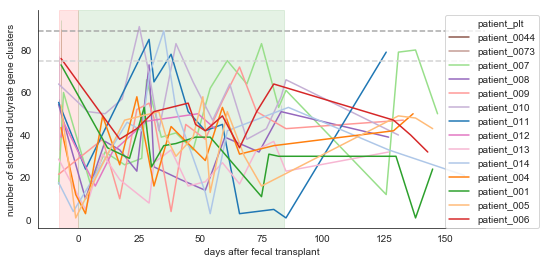

In [12]:
# for each patient, plot the total butyrate cluster counts over time

#get mean abundance for each donor
buty_mean_0044 = buty_ct.loc[buty_ct['patient'] == '0044']['sb_clust_count'].mean()
buty_mean_0073 = buty_ct.loc[buty_ct['patient'] == '0073']['sb_clust_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=buty_ct,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('number of shortbred butyrate gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

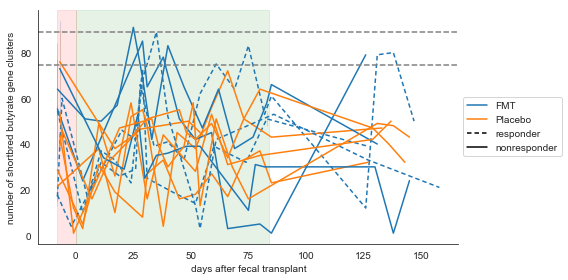

In [14]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=buty_ct,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name)

#label axes
ax.set_ylabel('number of shortbred butyrate gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='grey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='grey', linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_genecluster_counts_20190206.png',
            dpi=300)

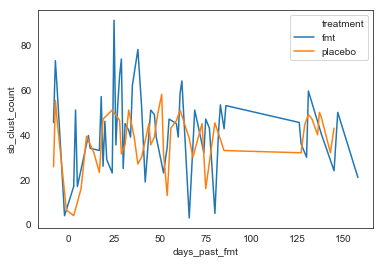

In [9]:
sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=buty_ct, hue='treatment', ci=None)

## Diversity of Butyrate pathways

1. What is the richness of different genes (ignoring taxa information) involved?

2. If we only count mostly complete pathways as present, how many pathways are present in each sample?

In [9]:
# get count of butyrate gene hits
buty_gene_ct = buty_f[['sample', 
                       'Count',
                       'gene_label']].groupby('sample')['gene_label'].nunique()
buty_gene_ct = buty_gene_ct.rename('buty_gene_count').reset_index()

#add metadata
buty_gene_ct = buty_gene_ct.merge(md, left_on='sample', right_on='sample_id')

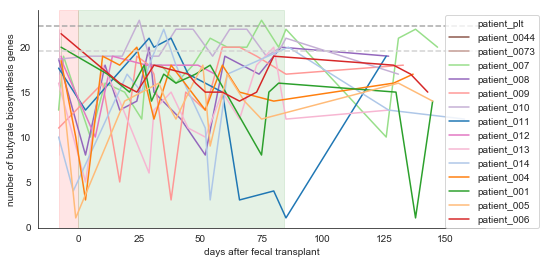

In [31]:
# for each patient, plot the butyrate biosynthessis gene counts over time

#get mean abundance for each donor
buty_mean_0044 = buty_gene_ct.loc[buty_gene_ct['patient'] == '0044']['buty_gene_count'].mean()
buty_mean_0073 = buty_gene_ct.loc[buty_gene_ct['patient'] == '0073']['buty_gene_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='buty_gene_count',
                  data=buty_gene_ct,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('number of butyrate biosynthesis genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

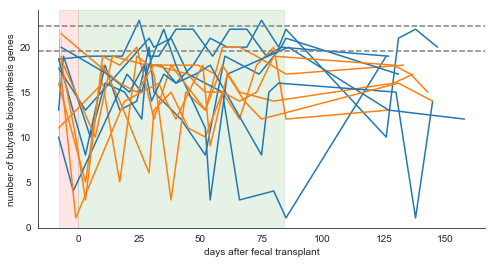

In [32]:
# for each patient, plot the butyrate biosynthessis gene counts over time

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='buty_gene_count',
                  data=buty_gene_ct,
                  hue='patient_plt', palette=dd_treat_col_name)

#label axes
ax.set_ylabel('number of butyrate biosynthesis genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='grey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='grey', linestyle='dashed')

ax.get_legend().remove()

sns.despine()

### Assess presense of different pathways

For each sample, let's evaluate the presense of each biosynthesis pathway. Let's first use strict cutoffs, which will mean that each gene had to be relatively robust in it's presense.

In [133]:
#make sets of genes for detecting different pathways
def buty_path_check(gene_list, gene_pathway_map, thresh=0.5):
    """
    assumes that the genes and associated pathways are in columns named
    "gene" and "pathway" respectively in the dataframe gene_pathway_map.
    
    Returns all pathways in which at least the fraction denoted by
    thresh of the genes are present in gene_list.
    """
    confirmed_pathways = []
    for pathway, sub_df in gene_pathway_map.groupby('pathway'):
        if len(set(gene_list) & set(sub_df['gene'])) > thresh * sub_df['gene'].nunique():
            confirmed_pathways.append(pathway)
    
    return confirmed_pathways

In [152]:
#get presense of pathways by sample
pathway_bysam = buty_f.groupby('sample')['gene_label'].apply(buty_path_check, 
                                                             gene_pathway_map=pathways)
pathway_bysam = pathway_bysam.rename('pathways_present').to_frame().reset_index()
pathway_bysam.loc[:, 'n_pathways'] = pathway_bysam['pathways_present'].str.len()
#add metadata
pathway_bysam = pathway_bysam.merge(md, left_on='sample', right_on='sample_id')

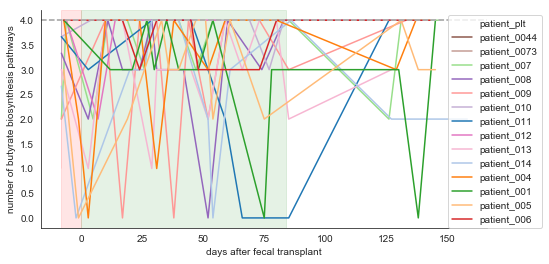

In [148]:
# for each patient, plot the number of butyrate pathways present

#get mean abundance for each donor
buty_mean_0044 = pathway_bysam.loc[pathway_bysam['patient'] == '0044']['n_pathways'].mean()
buty_mean_0073 = pathway_bysam.loc[pathway_bysam['patient'] == '0073']['n_pathways'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='n_pathways',
                  data=pathway_bysam,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('number of butyrate biosynthesis pathways')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

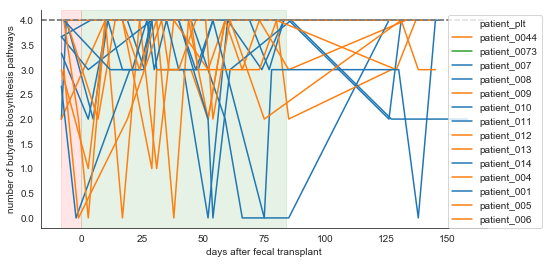

In [153]:
# for each patient, plot the number of butyrate pathways present

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='n_pathways',
                  data=pathway_bysam,
                  hue='patient_plt', palette=dd_treat_col_name)

#label axes
ax.set_ylabel('number of butyrate biosynthesis pathways')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color='grey', linestyle='dashed')
ax.axhline(buty_mean_0073, color='grey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

In [157]:
#get presense of pathways by sample
pathway_bysam = buty_f.groupby('sample')['gene_label'].apply(buty_path_check, 
                                                             gene_pathway_map=pathways,
                                                             thresh=0.6)
pathway_bysam = pathway_bysam.rename('pathways_present').to_frame().reset_index()
pathway_bysam.loc[:, 'n_pathways'] = pathway_bysam['pathways_present'].str.len()
#add metadata
pathway_bysam = pathway_bysam.merge(md, left_on='sample', right_on='sample_id')

So it looks like there are some interesting things happening where we can observe new organisms with new pathways coming in from the donors, who do tend to have a higher diversity of butyrate producing genes and organisms. 

Questions:

1. What

### PCoA of butyrate gene families

In [163]:
#make a feature table of the shortbred cluster count values
buty_f_ftab = buty_f.pivot(index='sample', columns='Family', values='Count')
buty_f_ftab = buty_f_ftab.fillna(0)

In [168]:
#get betadiversity
bray_buty = dist.squareform(dist.pdist(buty_f_ftab.values, metric='braycurtis'))
#make these into dataframes
bray_df = pd.DataFrame(bray_buty, columns=buty_f_ftab.index, index=buty_f_ftab.index)

In [170]:
#calculate pcoa
pcoa_bray = ordination.pcoa(bray_df)

#get pcoa results
pcoa_bray_coords = pcoa_bray.samples

#replace indexes
pcoa_bray_coords.index = bray_df.index

#add metadata to the dataframes
pcoa_bray_coords = pcoa_bray_coords.merge(md, left_index=True, 
                                          right_on='sample_id').sort_values('patient')

#make a patient category that doesn't look like numbers for seaborn
pcoa_bray_coords.loc[:, 'patient'] = 'patient_' + pcoa_bray_coords['patient']

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.298424412830824 and the largest is 13.01817104081393.
  RuntimeWarning


In [179]:
dd_treat_col_name

{'patient_0044': None,
 'patient_0073': None,
 'patient_001': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'patient_004': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_005': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_006': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_007': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'patient_008': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'patient_009': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_010': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'patient_011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'patient_012': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_013': (1.0, 0.4980392156862745, 0.054901960784313725),
 'patient_014': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}

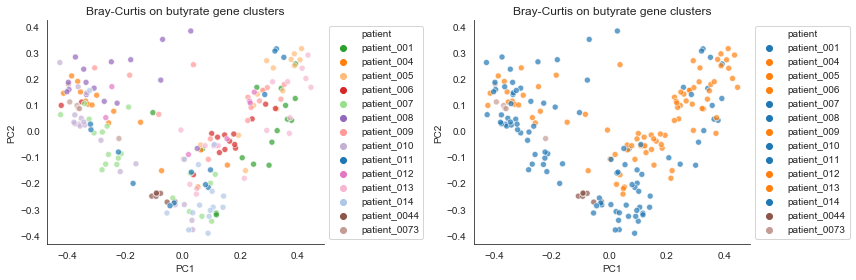

In [181]:
#plot these new pcoa points
hue_order = ['patient_001', 'patient_004', 'patient_005',
             'patient_006', 'patient_007', 'patient_008',
             'patient_009', 'patient_010', 'patient_011',
             'patient_012', 'patient_013', 'patient_014',
             'patient_0044', 'patient_0073']

fig = plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='PC1', y='PC2', hue='patient', data=pcoa_bray_coords,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('Bray-Curtis on butyrate gene clusters')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='PC1', y='PC2', hue='patient', data=pcoa_bray_coords,
                palette=dd_treat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('Bray-Curtis on butyrate gene clusters')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_mgx_NV022018.png',
#            dpi=300)
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_mgx_NV022018.pdf',
#            dpi=300)

In [176]:
pcoa_bray_coords[['PC1', 'PC2', 'patient']].loc[pcoa_bray_coords['patient'].isin(['patient_0044', 'patient_0073'])]

,PC1,PC2,patient
39,-0.107613,-0.249544,patient_0044
44,-0.092711,-0.250075,patient_0044
45,-0.077132,-0.238833,patient_0044
40,-0.091074,-0.239816,patient_0044
41,-0.027265,-0.270802,patient_0044
43,-0.054279,-0.272317,patient_0044
42,-0.091514,-0.237576,patient_0044
108,-0.367114,0.097210,patient_0073
109,-0.362510,0.087154,patient_0073
105,-0.397043,0.178558,patient_0073


## Which pathways transferred?

In [10]:
#get donor butyrate hits
d0044_buty = buty_f_md.loc[buty_f_md['patient'] == '0044']['Family'].unique()
d0073_buty = buty_f_md.loc[buty_f_md['patient'] == '0073']['Family'].unique()

donor_fams_dict = {'0044': d0044_buty, '0073': d0073_buty}

In [11]:
s3_eng_dfs = []

for patient, sub_df in buty_f_md.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        #get families
        bl_sam = sub_df.loc[sub_df['days_past_fmt'] < -5]['sample_id'].tolist()
        bl_fams = buty_f_md.loc[buty_f_md['sample'].isin(bl_sam)]['Family'].unique()
        
        #get donor
        donor = sub_df['fmt_induction'].iloc[0]
        donor_fams = donor_fams_dict[donor]
        
        #get families that occur post fmt in at least 3 samples
        pfmt_df = sub_df.loc[sub_df['days_past_fmt'] > 0]
        tmp = pfmt_df.groupby('Family').size()
        s3_post_fam = tmp.loc[tmp >= 3].index
        s3_eng_fam = (set(s3_post_fam) & set(donor_fams)) - set(bl_fams)
        
        #keep these entries
        sub_df.loc[:, 'patient'] = patient
        s3_eng_dfs.append(sub_df.loc[sub_df['Family'].isin(s3_eng_fam)])

s3_eng_df = pd.concat(s3_eng_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
# get count of butyrate gene cluster hits
s3_eng_ct = s3_eng_df[['sample', 
                       'Count']].groupby('sample').size().rename('sb_clust_count').reset_index()

#add metadata
s3_eng_ct = s3_eng_ct.merge(md, left_on='sample', right_on='sample_id')

In [45]:
#make a table of these genes
sub_table = s3_eng_df[['vital2017_faa_label', 'gene_label', 'taxa']].drop_duplicates()

#get a column of the gene names
tmp = sub_table['vital2017_faa_label'].str.partition(' ')[2]
tmp = tmp.str.split('[', expand=True)[0]

sub_table.loc[:, 'gene_name'] = tmp

sub_table[['gene_label', 
           'taxa', 'gene_name', 
           'vital2017_faa_label']].to_csv('/Users/ndchu/Documents/MIT/uc_fmt/metagenomics/function/butyrate/sb_OC312018/list_of_genes.tsv',
                                          sep='\t', index=False)

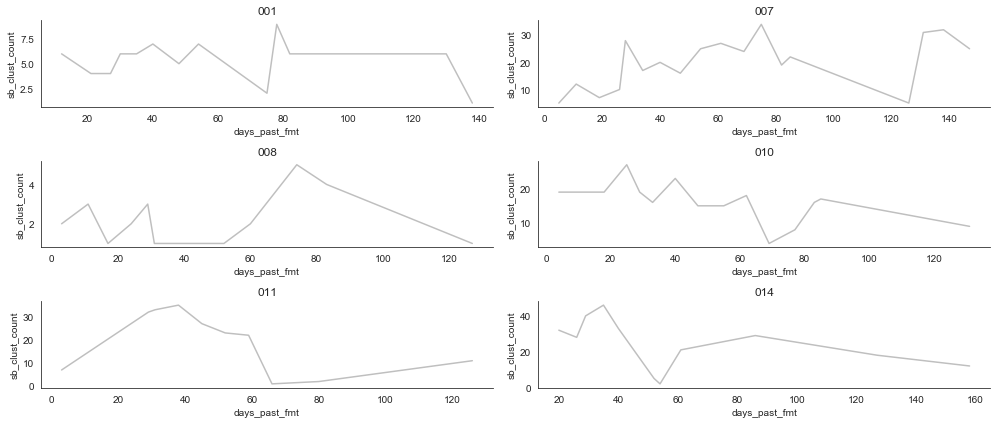

In [70]:
#plot these for each patient
fig = plt.figure(figsize = (14,6))

counter = 1
for patient, sub_df in s3_eng_ct.groupby('patient'):
    ax = fig.add_subplot(3,2,counter)
    
    sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                 data=sub_df, alpha=0.5,
                 estimator=None, color='grey'
                 )
    ax.set_title(patient)
    
    #ax.legend_.remove()
    
    counter += 1

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/soure_plot_mgx_abun_fmt_NV092018.png',
#            dpi=300)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


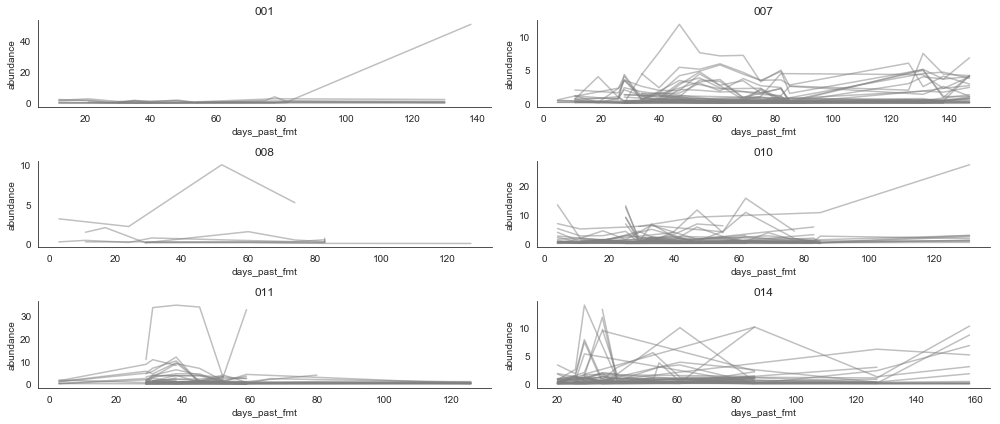

In [194]:
#plot these for each patient
fig = plt.figure(figsize = (14,6))

counter = 1
for patient, sub_df in s3_eng_df.groupby('patient'):
    ax = fig.add_subplot(3,2,counter)
    
    sub_df.loc[:, 'log_count'] = sub_df['Count'].apply(np.log10)
    
    sns.lineplot(x='days_past_fmt', y='Count',
                 units='Family', data=sub_df, alpha=0.5,
                 estimator=None, color='grey'
                 )
    ax.set_title(patient)
    ax.set_ylabel('abundance')
    
    #ax.legend_.remove()
    
    counter += 1

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_genecluster_abun_20190207.png',
#            dpi=300)

## Summing over windows of time

In [10]:
#let's get simply smash everything into 5-day windows
window_mean_dfs = []
for patient, sub_df in buty_ct.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'sb_clust_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['sb_clust_count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

window_mean_df = pd.concat(window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'clinical_response', 
             'patient_plt']].drop_duplicates()
window_mean_df = window_mean_df.merge(tmp_md)

#fill na with zero
window_mean_df['sb_clust_count'] = window_mean_df['sb_clust_count'].fillna(0)

In [12]:
#write this to a file
window_mean_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/butyrate/window_means_cts_2019-05-09.tsv',
                         sep='\t', index=False)

In [ ]:
#read this to a file
window_mean_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/butyrate/window_means_cts_2019-05-09.tsv',
                         sep='\t')

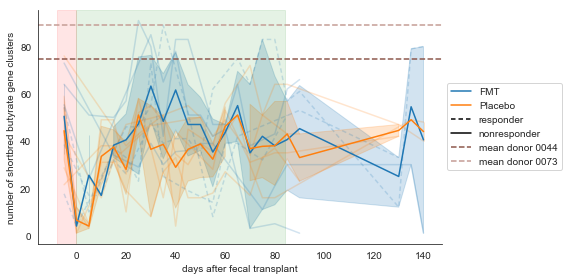

In [193]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='patient_plt', 
                  palette=dd_treat_col_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='treatment')

#label axes
ax.set_ylabel('number of shortbred butyrate gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(buty_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_genecluster_counts_20190206.png',
#            dpi=300)

In [13]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['sb_clust_count'], placebo['sb_clust_count'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


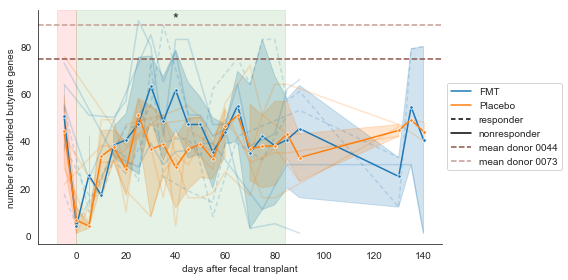

In [22]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

#get mean abundance for each donor
mean_0044 = buty_ct.loc[buty_ct['patient'] == '0044']['sb_clust_count'].mean()
mean_0073 = buty_ct.loc[buty_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('number of shortbred butyrate genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 90), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_genecluster_counts_mean_20190206.png',
            dpi=300)

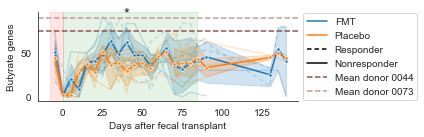

In [35]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (6,2))

#get mean abundance for each donor
mean_0044 = buty_ct.loc[buty_ct['patient'] == '0044']['sb_clust_count'].mean()
mean_0073 = buty_ct.loc[buty_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Butyrate genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 90), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_counts_mean_2019-04-16.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_counts_mean_2019-04-16.pdf',
            dpi=300)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


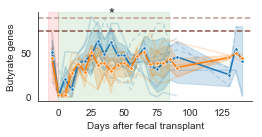

In [14]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (3.75,2))

#get mean abundance for each donor
mean_0044 = buty_ct.loc[buty_ct['patient'] == '0044']['sb_clust_count'].mean()
mean_0073 = buty_ct.loc[buty_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Butyrate genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 90), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_counts_mean_nolgd_2019-05-09.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_counts_mean_nolgd_2019-05-09.pdf',
            dpi=300)

### AUC

In [36]:
#for each patient, calculate the area under the curve
aucs_full = []
aucs_treatment = []
aucs_pfmt = []
for patient, sub_df in window_mean_df.groupby('patient'):
    #get full timeline
    auc = np.trapz(sub_df['sb_clust_count'], sub_df['chunk_time'])
    aucs_full.append([patient, auc])
    
    #get only treatment period
    tmp_df = sub_df.loc[sub_df['chunk_time'].between(1, 86)]
    auc = np.trapz(tmp_df['sb_clust_count'], tmp_df['chunk_time'])
    aucs_treatment.append([patient, auc])
    
    #get all of post fmt
    tmp_df = sub_df.loc[sub_df['chunk_time'] > 0]
    auc = np.trapz(tmp_df['sb_clust_count'], tmp_df['chunk_time'])
    aucs_pfmt.append([patient, auc])

In [37]:
aucs_full_df = pd.DataFrame(aucs_full, 
                            columns=['patient', 'auc'])
aucs_treatment_df = pd.DataFrame(aucs_treatment, 
                                 columns=['patient', 'auc'])
aucs_pfmt_df = pd.DataFrame(aucs_pfmt, 
                            columns=['patient', 'auc'])

aucs_full_df = aucs_full_df.merge(md_pat)
aucs_treatment_df = aucs_treatment_df.merge(md_pat)
aucs_pfmt_df = aucs_pfmt_df.merge(md_pat)

In [38]:
#get ttest for full period
tmp = stats.ttest_ind(aucs_full_df.loc[aucs_full_df['treatment'] == 'fmt']['auc'],
                      aucs_full_df.loc[aucs_full_df['treatment'] == 'placebo']['auc'])
print(tmp)

#get ttest for treatment period
tmp = stats.ttest_ind(aucs_treatment_df.loc[aucs_treatment_df['treatment'] == 'fmt']['auc'],
                      aucs_treatment_df.loc[aucs_treatment_df['treatment'] == 'placebo']['auc'])
print(tmp)

#get ttest for treatment and followup
tmp = stats.ttest_ind(aucs_pfmt_df.loc[aucs_pfmt_df['treatment'] == 'fmt']['auc'],
                      aucs_pfmt_df.loc[aucs_pfmt_df['treatment'] == 'placebo']['auc'])
print(tmp)

Ttest_indResult(statistic=0.7152992063748783, pvalue=0.4907873487233493)
Ttest_indResult(statistic=0.9321728083465024, pvalue=0.3732060836421114)
Ttest_indResult(statistic=0.5663540582139319, pvalue=0.5836390896558998)


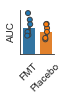

In [39]:
#plot aucs during
fig = plt.figure(figsize = (1,1.5))

ax = sns.barplot(x='treatment', y='auc', data=aucs_treatment_df)
ax = sns.stripplot(x='treatment', y='auc', data=aucs_treatment_df,
                   linewidth=1)
ax.set_ylabel('AUC')
ax.set_xlabel('')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'FMT'
labels[1] = 'Placebo'
ax.set_xticklabels(labels)

#remove y ticks
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)

#remove x ticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    rotation=45)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_auc_2019-04-15.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_auc_2019-04-15.pdf',
            dpi=300)

### Try 10-day window

In [195]:
#let's get simply smash everything into 10-day windows
window10_mean_dfs = []
for patient, sub_df in buty_ct.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'sb_clust_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 10),
                         range(10, int(sub_df['days_past_fmt'].max()), 10)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['sb_clust_count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    window10_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

window10_mean_df = pd.concat(window10_mean_dfs)

In [198]:
#add metadata
window10_mean_df = window10_mean_df.merge(tmp_md)

In [199]:
for time, sub_df in window10_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['sb_clust_count'], placebo['sb_clust_count'])
    print(time, t_res)

-5.0 Ttest_indResult(statistic=0.5418712637155297, pvalue=0.5997721773831026)
0.0 Ttest_indResult(statistic=nan, pvalue=nan)
10.0 Ttest_indResult(statistic=nan, pvalue=nan)
20.0 Ttest_indResult(statistic=0.9896819793451811, pvalue=0.34818915739187384)
30.0 Ttest_indResult(statistic=1.3544667641595416, pvalue=0.20861142795094748)
40.0 Ttest_indResult(statistic=1.471857611303462, pvalue=0.17514278175926887)
50.0 Ttest_indResult(statistic=0.5870958860491041, pvalue=0.5715711661833133)
60.0 Ttest_indResult(statistic=-0.057528198990305916, pvalue=0.955381445090985)
70.0 Ttest_indResult(statistic=0.1409744706014369, pvalue=0.8913752418172187)
80.0 Ttest_indResult(statistic=-0.1399378192285562, pvalue=0.8921681490112143)
90.0 Ttest_indResult(statistic=-0.025969098926448005, pvalue=0.9799180890430951)
130.0 Ttest_indResult(statistic=-2.2495840650671552, pvalue=0.10998043911819044)
140.0 Ttest_indResult(statistic=0.10067843991470969, pvalue=0.9289893087246781)


### Try on pathway diveristy

In [201]:
#let's get simply smash everything into 5-day windows
ca_window5_mean_dfs = []
for patient, sub_df in buty_gene_ct.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['buty_gene_count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'buty_gene_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['buty_gene_count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['buty_gene_count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    ca_window5_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

ca_window5_mean_df = pd.concat(ca_window5_mean_dfs)

In [202]:
#add metadata
ca_window5_mean_df = ca_window5_mean_df.merge(tmp_md)

In [204]:
for time, sub_df in ca_window5_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['buty_gene_count'], placebo['buty_gene_count'])
    print(time, t_res)

-5.0 Ttest_indResult(statistic=-0.12172614291494331, pvalue=0.9055272648100379)
0.0 Ttest_indResult(statistic=nan, pvalue=nan)
5.0 Ttest_indResult(statistic=2.3296416134136075, pvalue=0.08028360526356573)
10.0 Ttest_indResult(statistic=nan, pvalue=nan)
15.0 Ttest_indResult(statistic=-0.5222329678670935, pvalue=0.6202199660794111)
20.0 Ttest_indResult(statistic=0.9392430353709925, pvalue=0.3788760917734524)
25.0 Ttest_indResult(statistic=-0.27719219881253343, pvalue=0.7927273859785238)
30.0 Ttest_indResult(statistic=1.3795305076179831, pvalue=0.21018807338024623)
35.0 Ttest_indResult(statistic=1.9087023470218663, pvalue=0.08864549775190739)
40.0 Ttest_indResult(statistic=2.163419027553844, pvalue=0.06726749046653312)
45.0 Ttest_indResult(statistic=1.5540252531155458, pvalue=0.15878463916811986)
50.0 Ttest_indResult(statistic=1.6193756890782394, pvalue=0.15649369195171323)
55.0 Ttest_indResult(statistic=0.6985135833240594, pvalue=0.5025044826062217)
60.0 Ttest_indResult(statistic=0.36454

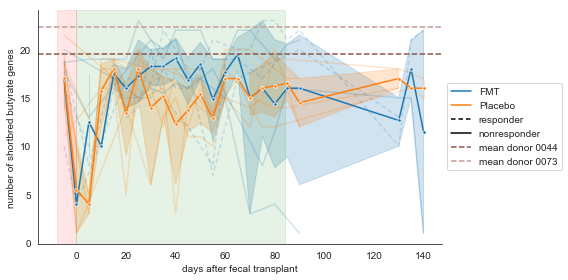

In [213]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

#get mean abundance for each donor
buty_mean_0044 = buty_gene_ct.loc[buty_gene_ct['patient'] == '0044']['buty_gene_count'].mean()
buty_mean_0073 = buty_gene_ct.loc[buty_gene_ct['patient'] == '0073']['buty_gene_count'].mean()

ax = sns.lineplot(x='chunk_time', y='buty_gene_count',
                  data=ca_window5_mean_df,
                  hue='patient_plt', 
                  palette=dd_treat_col_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='buty_gene_count',
                  data=ca_window5_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('number of shortbred butyrate genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(buty_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(buty_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_genecluster_counts_20190206.png',
#            dpi=300)

## Butyrate source tracking

In [15]:
#colors for sources
dd_source_set = {'shared': (0.878, 0.878, 0.878),
                 'patient': (0.909, 0.470, 0.470),
                 'env': (0.933, 0.674, 0.349),
                 'donor0044': (0.305, 0.749, 0.776),
                 'donor0073': (0.643, 0.450, 0.850),
                 'donor0044_0073': (0.376, 0.470, 0.803),
                 'donor': (0.376, 0.470, 0.803)}

#make a dictionary of patient to publication label
pub_label_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [10]:
#make gene dict
donor_gene_dict = {'0044': set(buty_f_md.loc[buty_f_md['patient'] == '0044']['Family']),
                   '0073': set(buty_f_md.loc[buty_f_md['patient'] == '0073']['Family'])}

buty_source = []
for patient, sub_df in buty_f_md.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline vf genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_genes = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    for sample, sub_sub_df in sub_df.groupby('sample_id'):
        sam_genes = set(sub_sub_df['Family'])
        
        if sub_df['treatment'].iloc[0] == 'placebo':
            pat_genes = sam_genes & bl_genes #patient vf
            env_genes = sam_genes - bl_genes #env vf
            
            buty_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_genes])
            buty_source.extend([[patient, sample, 
                                x, 'env'] for x in env_genes])
        
        elif sub_df['treatment'].iloc[0] == 'fmt':
            donor = sub_df['fmt_induction'].iloc[0]
            donor_genes = donor_gene_dict[donor]
            
            pat_genes = (sam_genes & bl_genes) - donor_genes #patient amr
            don_genes = (donor_genes & sam_genes) - bl_genes #donor amr
            shr_genes = donor_genes & sam_genes & bl_genes #shared amr
            env_genes = sam_genes - donor_genes - bl_genes #env amr
            
            buty_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_genes])
            buty_source.extend([[patient, sample, 
                                x, 'env'] for x in env_genes])
            buty_source.extend([[patient, sample, 
                                x, 'donor'] for x in don_genes])
            buty_source.extend([[patient, sample, 
                                x, 'shared'] for x in shr_genes])

buty_source_df = pd.DataFrame(buty_source, 
                              columns=['patient', 'sample_id', 
                                       'Family', 'source'])

In [11]:
# add metadata
buty_source_df = buty_source_df.merge(buty_f_md)

In [12]:
# write to a file
buty_source_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/butyrate/buty_source_2019-05-05.tsv.gz',
                     sep='\t', index=False, compression='gzip')

In [16]:
# read in a file
buty_source_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/butyrate/buty_source_2019-05-05.tsv.gz',
                           sep='\t', compression='gzip', dtype={'patient': 'object',
                                                                'fmt': 'object',
                                                                'fmt_induction': 'object'})

In [22]:
# get frequencies over time
buty_source_freq = buty_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source']).size()
buty_sample_sum = buty_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt']).size()

buty_source_freq = buty_source_freq.rename('source_count').reset_index()
buty_sample_sum = buty_sample_sum.rename('buty_count').reset_index()

buty_source_freq = buty_source_freq.merge(buty_sample_sum)
buty_source_freq.loc[:, 'source_freq'] = buty_source_freq['source_count'] / buty_source_freq['buty_count']

In [37]:
#get rid of samples with less than 2 butyrate genes, since they are likely errors
buty_source_freq = buty_source_freq.loc[buty_source_freq['buty_count'] > 1]

#fill the zeroes
buty_source_freq_ftab = buty_source_freq.pivot(index='sample_id',
                                               columns='source',
                                               values='source_freq')
buty_source_freq_filled = pd.melt(buty_source_freq_ftab.reset_index(),
                                  id_vars='sample_id',
                                  var_name='source',
                                  value_name='source_freq')
#add metadata
buty_source_freq_filled = buty_source_freq_filled.fillna(0)
tmp = buty_source_freq[['sample_id', 'source', 'source_count']]
buty_source_freq_filled = buty_source_freq_filled.merge(tmp, how='outer').fillna(0)
tmp = buty_source_freq[['sample_id', 'buty_count']].drop_duplicates()
buty_source_freq_filled = buty_source_freq_filled.merge(tmp)
buty_source_freq_filled = buty_source_freq_filled.merge(md)

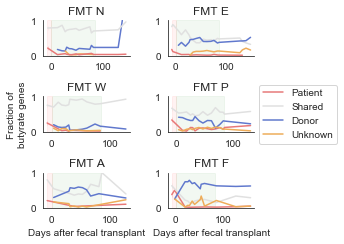

In [25]:
# plot these buty sources
#collapse all donor categories

fig = plt.figure(figsize = (5,3.5))

counter = 1
for patient, sub_df in buty_source_freq.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Fraction of\nbutyrate genes')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_2019-05-04.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_2019-05-04.pdf',
            dpi=300)

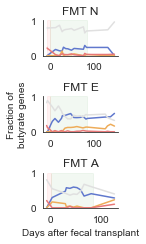

In [39]:
# plot FMT N, E, and A

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in buty_source_freq_filled.groupby('patient'):
    if patient in ['001', '007', '011']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nbutyrate genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_NEA_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_NEA_2019-05-07.pdf',
            dpi=300)

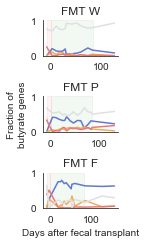

In [40]:
# plot FMT WPF

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in buty_source_freq_filled.groupby('patient'):
    if patient in ['008', '010', '014']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nbutyrate genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_WPF_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/buty_engfmt_ts_WPF_2019-05-07.pdf',
            dpi=300)